# setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
from cmcrameri import cm
import cartopy.feature as cf
import regionmask

In [2]:
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\seasonal\trend'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\seasonal\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
seasons = ['DJF', 'MAM', 'JJA', 'SON']



In [3]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


In [4]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds['trend_ratio'] = ds['slopes'] / ds['intercepts']  * 100
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [5]:
for season in seasons:
    stations['trend_ratio_' + str(season)] = stations['slope_' + str(season)]/ stations['intercept_' + str(season)] * 100

#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['Region', 'season','Dataset', 'slopes', 'p_values','trend_ratio']]
df['Region'] = df['Region'].replace(regions_replace)

#in stations transform slope_season in column total and season
stations_season = stations.melt(id_vars=['Code', 'Region'], value_vars=['slope_DJF', 'slope_MAM', 'slope_JJA', 'slope_SON'], var_name='season', value_name='slopes').dropna().reset_index(drop=True)
stations_season['trend_ratio'] =  stations.melt(id_vars=['Code', 'Region'], value_vars=['trend_ratio_DJF', 'trend_ratio_MAM', 'trend_ratio_JJA', 'trend_ratio_SON'], var_name='season', value_name='trend_ratio').dropna().reset_index(drop=True)['trend_ratio']
stations_season['p_values']=  stations.melt(id_vars=['Code', 'Region'], value_vars=['p_DJF', 'p_MAM', 'p_JJA', 'p_SON'], var_name='season', value_name='p').dropna().reset_index(drop=True)['p']
#in season just the last 3 letters
stations_season['season'] = stations_season['season'].str[-3:]
stations_season.drop(columns=['Code'], inplace=True)
stations_season['Dataset'] = 'Stations'
df = df.append(stations_season)

C:\Users\luisg\AppData\Local\Temp\ipykernel_6084\700404410.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_6084\700404410.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_6084\700404410.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_6084\700404410.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_6084\700404410.py:9: FutureWarning: The frame.append method is deprecated an

C:\Users\luisg\AppData\Local\Temp\ipykernel_6084\4018761517.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


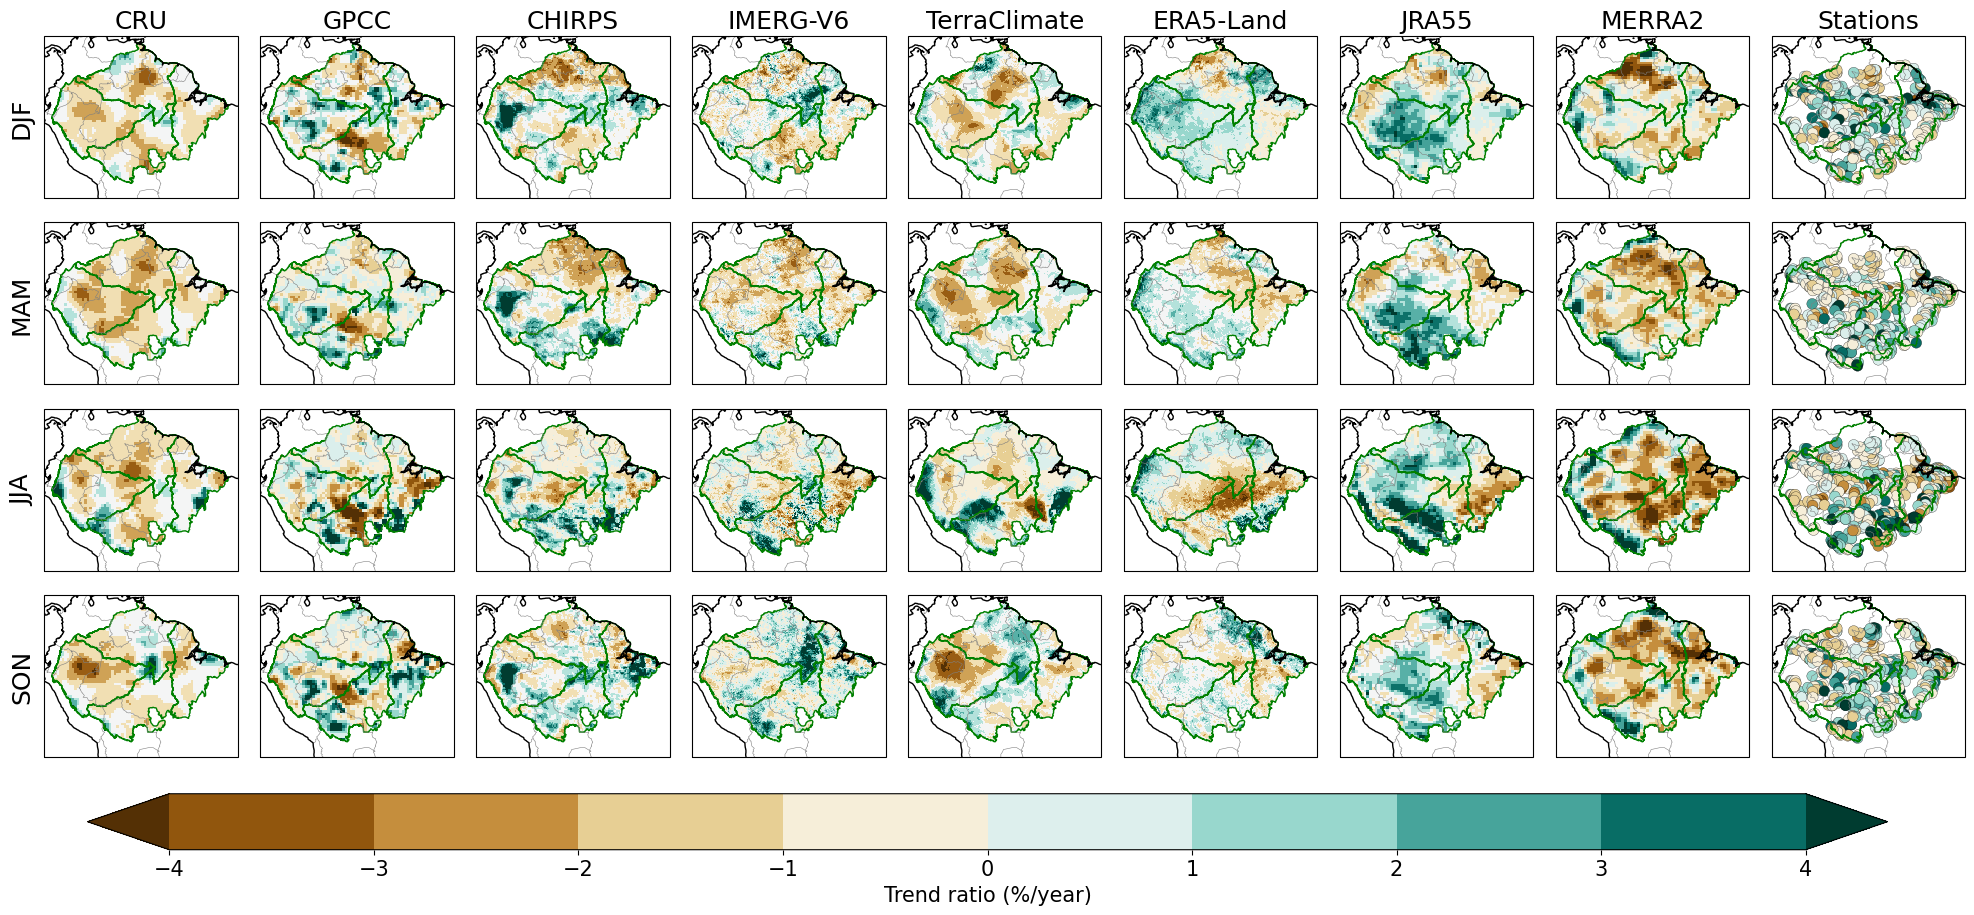

In [10]:
## season
vmin = -4
vmax = 4
levels = 9
cmap = mpl.cm.BrBG#mpl.cm.RdBu
extend_cbar = 'both'
var = 'trend_ratio'
var_stat = 'trend_ratio_'
label_cbar = 'Trend ratio (%/year)'


#####
bounds = np.linspace(vmin,vmax,levels)
proj = ccrs.Mercator()
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
seasons = ['DJF', 'MAM', 'JJA', 'SON']
extend = [-81, -42, -20, 11]
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(ncols=len(datasets)+1, nrows=4, figsize=(20, 8), subplot_kw={'projection': proj})
#create cax in the bottom of the figure
cax = fig.add_axes([0.05, -0.08, 0.9, 0.07])

fig.colorbar(sm, cax=cax, orientation='horizontal', label=label_cbar )

for axx in axes.flatten():
        axx.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        axx.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        axx.set_extent([-81, -42, -20, 11])
        axx.coastlines()  
        # Add a title for each subplot
        #ax.set_title(datasets_names[i])
        # Remove x and y labels  
    

for i, name in enumerate(datasets_names):
    for j in range(4):
        ax = axes[j, i]
        ds = ds_dict[name]
        ds.sel(season=seasons[j])[var].plot(ax= axes[j, i] , cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels= levels)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        
          
        if i == 0:
            axes[j, i].set_ylabel(seasons[j], fontsize=18)
        if j == 0:
            axes[j, i].set_title(datasets_names[i], fontsize=18)
#plot the stations season metrics
for j in range(4):
    stations.to_crs(proj).plot(ax=axes[j, 8], column=var_stat + seasons[j], cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black', s=60)
  
  
    if j == 0:
        axes[j, 8].set_title('Stations')

plt.tight_layout()

C:\Users\luisg\AppData\Local\Temp\ipykernel_3816\2767246048.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


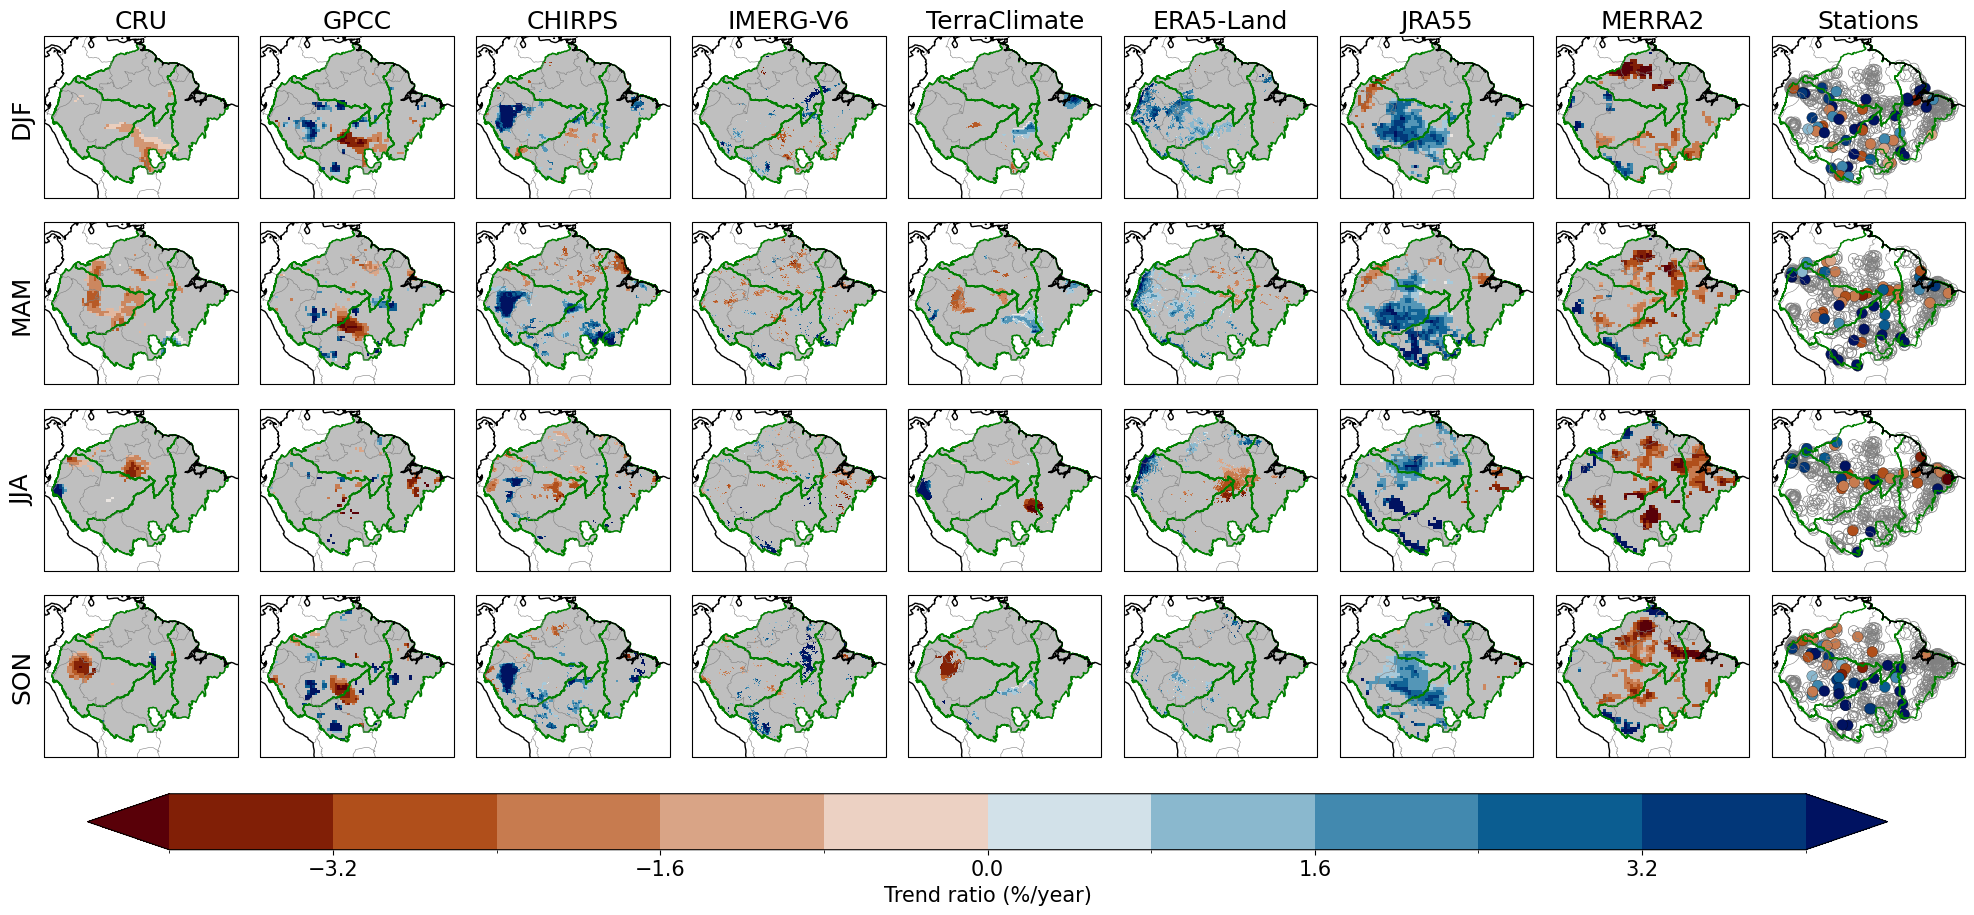

In [23]:
## season
vmin = -4
vmax = 4
levels = 11
cmap = cm.vik_r#mpl.cm.RdBu
extend_cbar = 'both'
var = 'trend_ratio'
var_stat = 'trend_ratio_'
label_cbar = 'Trend ratio (%/year)'


#####
bounds = np.linspace(vmin,vmax,levels)
proj = ccrs.Mercator()
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
seasons = ['DJF', 'MAM', 'JJA', 'SON']
extend = [-81, -42, -20, 11]
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(ncols=len(datasets)+1, nrows=4, figsize=(20, 8), subplot_kw={'projection': proj})
#create cax in the bottom of the figure
cax = fig.add_axes([0.05, -0.08, 0.9, 0.07])

fig.colorbar(sm, cax=cax, orientation='horizontal', label=label_cbar)

for axx in axes.flatten():
        axx.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        axx.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        axx.set_extent([-81, -42, -20, 11])
        axx.coastlines()  
        # Add a title for each subplot
        #ax.set_title(datasets_names[i])
        # Remove x and y labels  
    

for i, name in enumerate(datasets_names):
    for j in range(4):
        ax = axes[j, i]
        ds = ds_dict[name]
        ds.where(ds['p_values'] <= 0.05).sel(season=seasons[j])[var].plot(ax= axes[j, i] , cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels= levels)
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='green', linewidth=1, zorder=-30,alpha=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        
          
        if i == 0:
            axes[j, i].set_ylabel(seasons[j], fontsize=18)
        if j == 0:
            axes[j, i].set_title(datasets_names[i], fontsize=18)
#plot the stations season metrics
for j in range(4):
    stations[stations['p_' + seasons[j]] <= 0.05].to_crs(proj).plot(ax=axes[j, 8], column=var_stat + seasons[j], cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black', s=60)
    stations[stations['p_' + seasons[j]] >= 0.05].to_crs(proj).plot(ax=axes[j, 8], markersize=60, facecolor='none', linewidth=0.5, edgecolor='grey',zorder=-10)
  
    if j == 0:
        axes[j, 8].set_title('Stations')

plt.tight_layout()

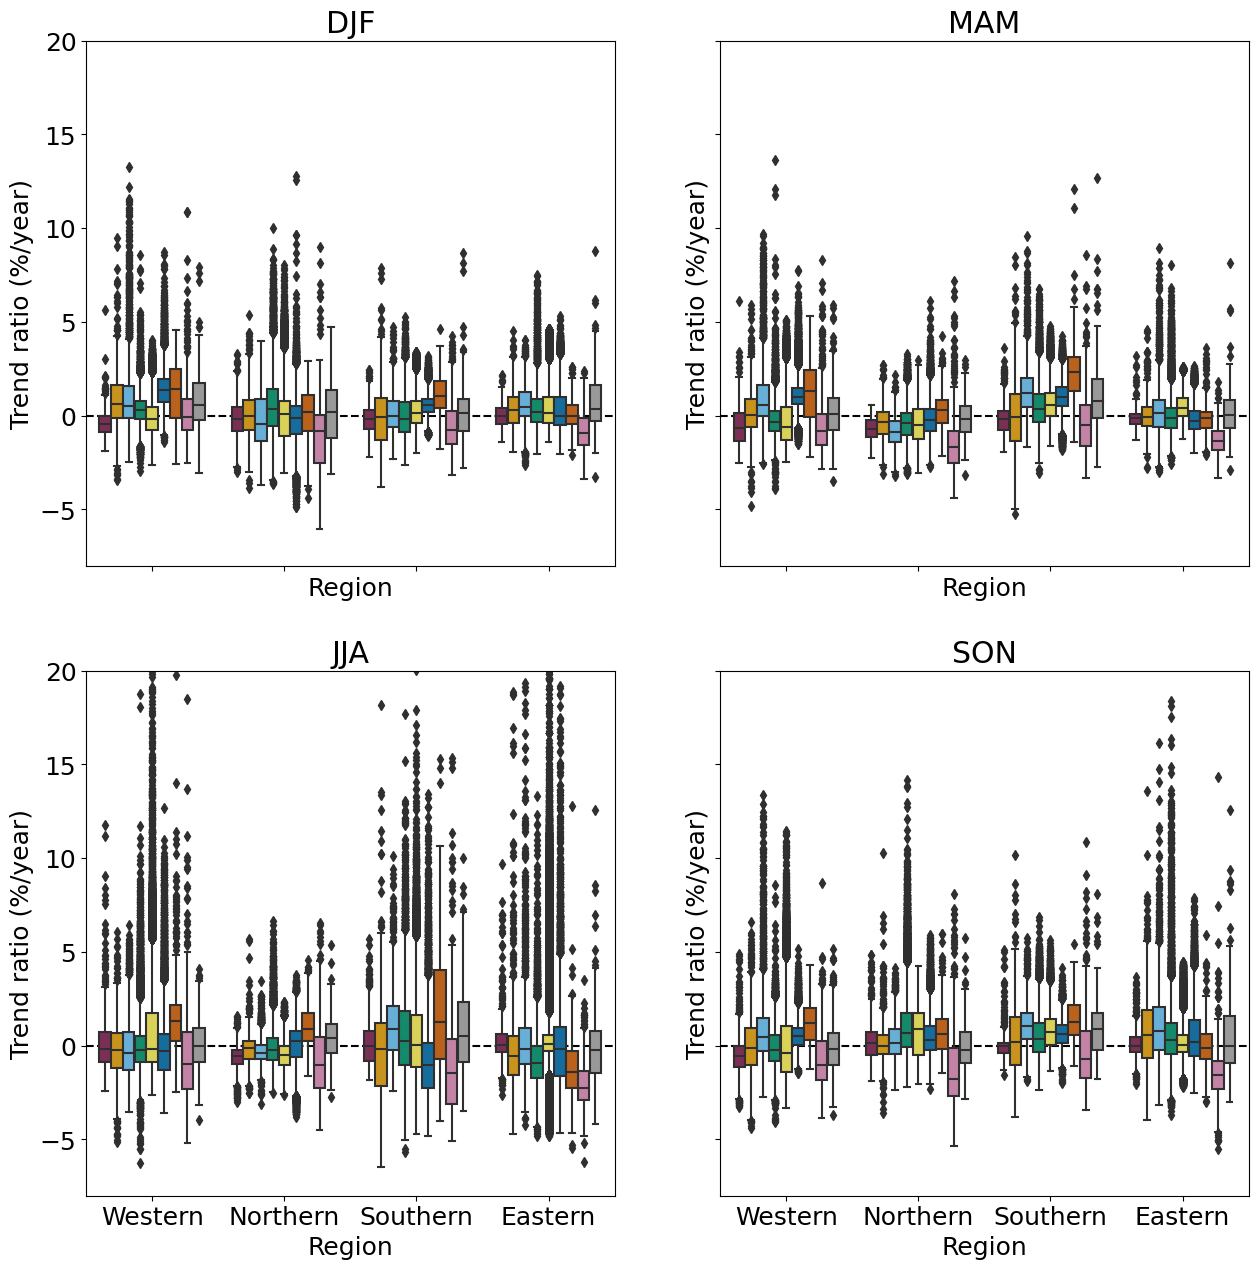

In [102]:
fig, axes = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True)
metric = 'trend_ratio'
axes = axes.flatten()
for i, season in enumerate(seasons):
    df_season = df[df['season'] == season]
    sns.boxplot( y=metric,x="Region", data=df_season, ax=axes[i], hue_order=hue_order, palette=wong, hue='Dataset').get_legend().remove()
    axes[i].set_ylim(-8,20)
    axes[i].set_title(season)
    axes[i].set_ylabel('Trend ratio (%/year)')
    #plot h line in 0
    axes[i].axhline(y=0, color='k', linestyle='--', zorder=-20)

# point

In [6]:
#in stations transform slope_season in column total and season
stations_season = stations.melt(id_vars=['Code', 'Region'], value_vars=['slope_DJF', 'slope_MAM', 'slope_JJA', 'slope_SON'], var_name='season', value_name='slopes').dropna().reset_index(drop=True)
stations_season['trend_ratio'] =  stations.melt(id_vars=['Code', 'Region'], value_vars=['trend_ratio_DJF', 'trend_ratio_MAM', 'trend_ratio_JJA', 'trend_ratio_SON'], var_name='season', value_name='trend_ratio').dropna().reset_index(drop=True)['trend_ratio']
stations_season['p_values']=  stations.melt(id_vars=['Code', 'Region'], value_vars=['p_DJF', 'p_MAM', 'p_JJA', 'p_SON'], var_name='season', value_name='p').dropna().reset_index(drop=True)['p']
#in season just the last 3 letters
stations_season['season'] = stations_season['season'].str[-3:]
stations_season = stations_season.merge(stations[['Code','geometry']], on='Code')
data = stations_season[['geometry','slopes','trend_ratio','season']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'trend_ratio'

In [7]:
metrics_dict = {}
for name in datasets_names:
    ds = ds_dict[name].copy()
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    for var in ['trend_ratio', 'slopes']:

        # Step 3: Compute the mean value for each grid cell and each year
        grid_cells = data.groupby(['lat_bin', 'lon_bin','season'])[var].mean().reset_index()
        # Step 4: Create an empty DataArray with NaN values
        empty_grid = np.full((4,len(ds_grid_lat), len(ds_grid_lon)), np.nan)
        # Step 5: Fill the DataArray with the computed mean values for each year
        for _, row in grid_cells.iterrows():
            season_idx = np.where(data['season'].unique() == row['season'])[0][0]
            #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
            lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
            lat_idx, lon_idx = int(lat_idx), int(lon_idx)
            empty_grid[season_idx,lat_idx - 1, lon_idx - 1] = row[var]
        # Step 6: Create an xarray DataArray from the result with the year dimension
        #year_coords = data['year'].unique()
        season_coords = data['season'].unique()
        data_array = xr.DataArray(empty_grid,
                                    dims=('season','lat', 'lon'),
                                    coords={'season':season_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})
        # Calculate various metrics
        ds[var + '_stat'] = data_array
    metrics_dict[name] = ds

In [8]:
df_compare = pd.DataFrame()
for name in datasets_names:
    df_comparef =  metrics_dict[name].to_dataframe().dropna().reset_index()
    df_comparef['Dataset'] = name
    df_compare = df_compare.append(df_comparef)

df_compare = df_compare[['p_values','season', 'Region', 'Dataset','trend_ratio', 'trend_ratio_stat', 'slopes','slopes_stat']]
df_compare['Region'] = df_compare['Region'].replace(regions_replace)

C:\Users\luisg\AppData\Local\Temp\ipykernel_3816\240903022.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_3816\240903022.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_3816\240903022.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_3816\240903022.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\L

In [9]:
marker_list = ['*','.' ]
marker_dict = {'DJF':'*', 'JJA':'.'}
marker_legend = [Line2D([0], [0],  marker='*', color='w', label='DJF', markerfacecolor='black', markersize=12),
                  Line2D([0], [0],  marker='.', color='w', label='JJA', markerfacecolor='black', markersize=12)]
marker_legend = marker_legend +  legend_elements_b


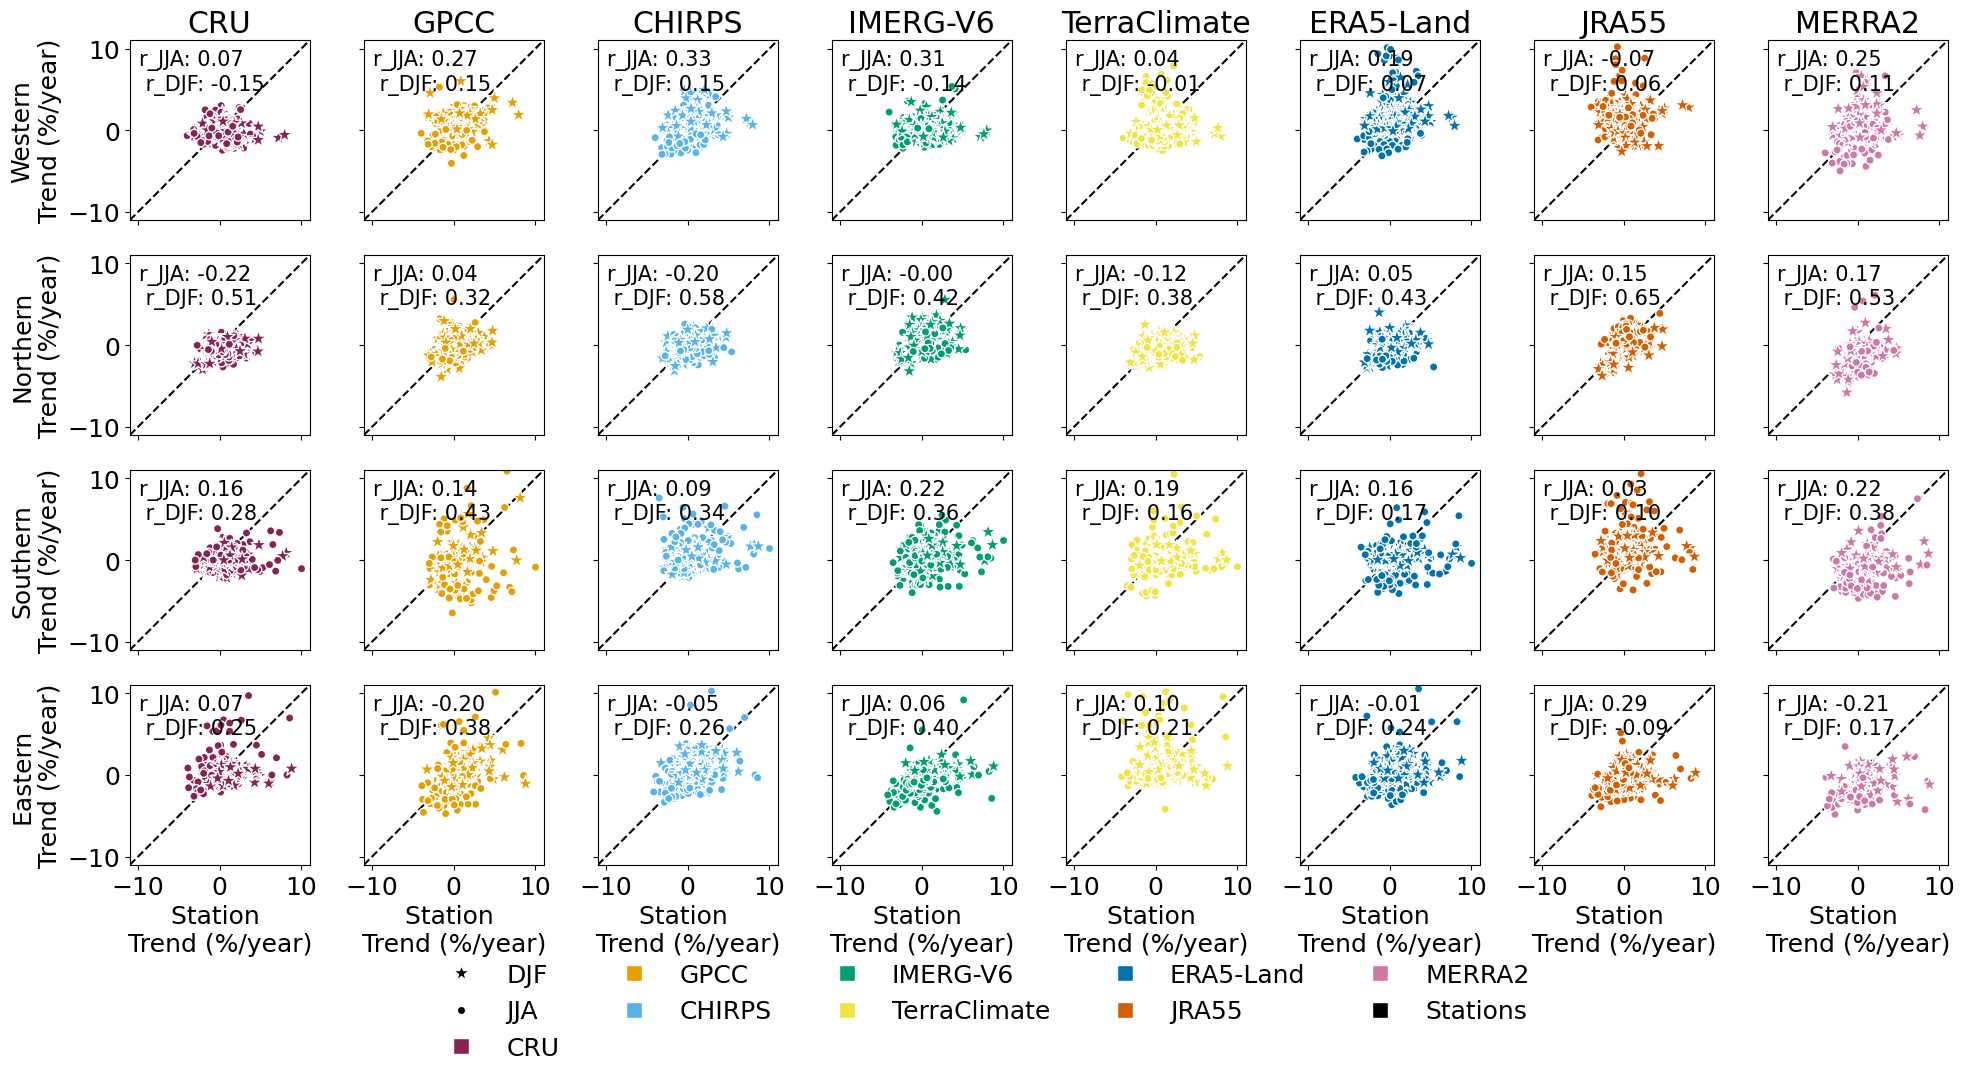

In [10]:
fig, axes = plt.subplots(4,8, figsize=(20,10), sharex=True, sharey=True)
limm = 11
df_ss = df_compare[df_compare['season'].isin(['DJF', 'JJA'])]
for i, name in enumerate(datasets_names):
    df_ds = df_ss[df_ss ['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='trend_ratio_stat', y='trend_ratio', ax=axes[j,i], s=140,
                        color=wong[i], legend=False, style='season',style_order=['DJF', 'JJA'],
                        markers=marker_dict)
        
        axes[j,i].set_xlabel('Station \nTrend (%/year)')
        axes[j,i].set_ylabel(region + '\nTrend (%/year)')
        axes[j,i].set_xlim(-limm,limm)
        axes[j,i].set_ylim(-limm,limm)
        axes[j,i].plot([-limm,limm],[-limm,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        dff_jja = df_plot[df_plot['season'] == 'JJA']
        corr_jja = dff_jja['trend_ratio_stat'].corr(dff_jja['trend_ratio'])
        dff_djf = df_plot[df_plot['season'] == 'DJF']
        corr_djf = dff_djf['trend_ratio_stat'].corr(dff_djf['trend_ratio'])
        axes[j,i].text(0.05, 0.95, f'r_JJA: {corr_jja:.2f} \n r_DJF: {corr_djf:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=marker_legend, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()

In [16]:
df_rr = df_compare.groupby(['Region','season', 'Dataset']).apply(lambda x: x['trend_ratio'].corr(x['trend_ratio_stat'])).reset_index(name='corr')
df_rr.groupby(['season','Region'])['corr'].mean()

# hatch

In [11]:
#import mpatches
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
legend_elements_sig = [(mpatches.Patch(facecolor='grey', edgecolor='black', hatch='///'),
                        Line2D([0], [0],  marker='o', color='w', markerfacecolor='grey', markersize=12, markeredgewidth=1.5, markeredgecolor='black')),
                          (mpatches.Patch(facecolor='grey', edgecolor='black'),
                           Line2D([0], [0],  marker='o', color='w', markerfacecolor='none', markersize=12, markeredgecolor='black', markeredgewidth=1.5))]

C:\Users\luisg\AppData\Local\Temp\ipykernel_19312\2511502433.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


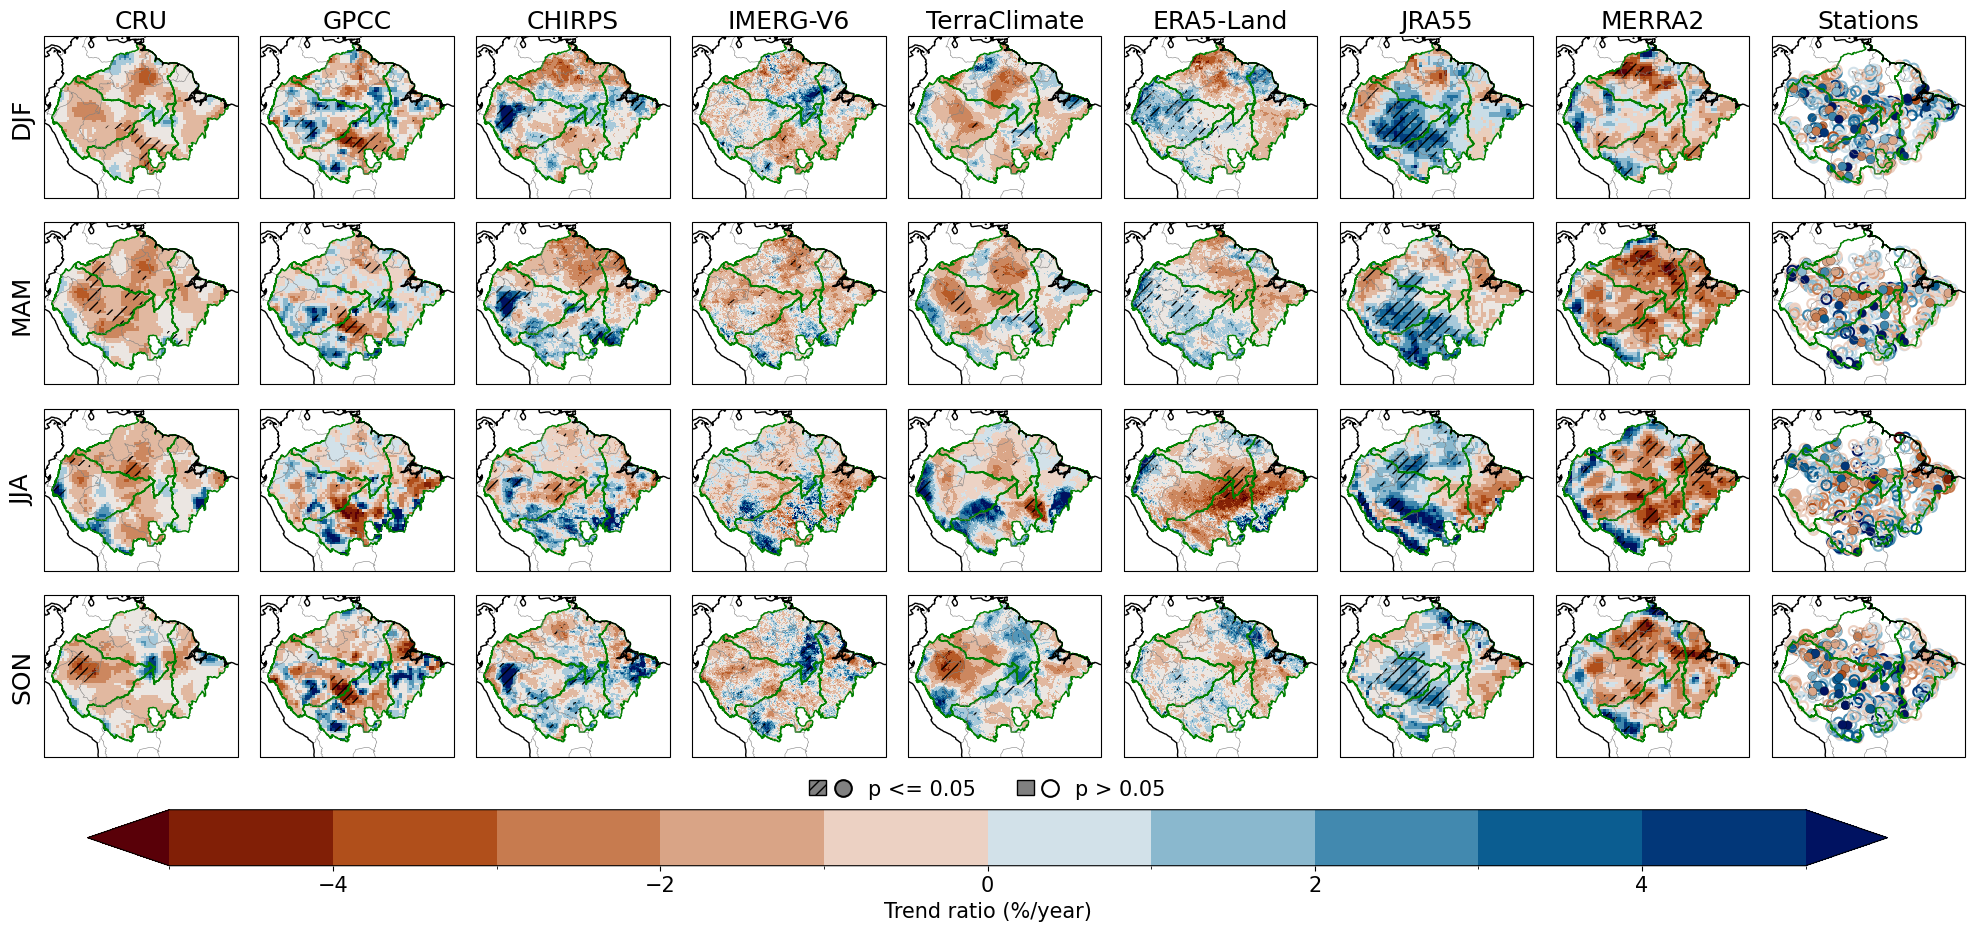

In [19]:
## season
vmin = -5
vmax = 5
levels = 11
cmap = cm.vik_r#mpl.cm.RdBu
extend_cbar = 'both'
var = 'trend_ratio'
var_stat = 'trend_ratio_'
label_cbar = 'Trend ratio (%/year)'


#####
bounds = np.linspace(vmin,vmax,levels)
proj = ccrs.Mercator()
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
seasons = ['DJF', 'MAM', 'JJA', 'SON']
extend = [-81, -42, -20, 11]
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(ncols=len(datasets)+1, nrows=4, figsize=(20, 8), subplot_kw={'projection': proj})
#create cax in the bottom of the figure
cax = fig.add_axes([0.05, -0.1, 0.9, 0.07])

fig.colorbar(sm, cax=cax, orientation='horizontal', label=label_cbar )

for axx in axes.flatten():
        axx.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        axx.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        axx.set_extent([-81, -42, -20, 11])
        axx.coastlines()  
        # Add a title for each subplot
        #ax.set_title(datasets_names[i])
        # Remove x and y labels  
    

for i, name in enumerate(datasets_names):
    for j in range(4):
        ax = axes[j, i]
        ds = ds_dict[name]
        ds.sel(season=seasons[j])[var].plot(ax= axes[j, i] , cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels= levels)
        ds.where(ds['p_values'] <= 0.05).sel(season=seasons[j])[var].plot.contourf(ax= axes[j, i], colors='none', hatches=['///'], add_colorbar=False,transform=ccrs.PlateCarree())

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        
          
        if i == 0:
            axes[j, i].set_ylabel(seasons[j], fontsize=18)
        if j == 0:
            axes[j, i].set_title(datasets_names[i], fontsize=18)
#plot the stations season metrics
for j in range(4):
    stations[stations['p_' + seasons[j]] <= 0.05].to_crs(proj).plot(ax=axes[j, 8], column=var_stat + seasons[j], cmap=cmap,   scheme="User_Defined", 
                classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black', s=40)
    
    #stations[stations['p_' + seasons[j]] <= 0.05]
    stations[stations['p_' + seasons[j]] > 0.05].to_crs(proj).plot(edgecolor=cmap(norm(stations[var_stat+ seasons[j]].values)), linewidth=1.5, marker='o', markersize=50,
                                           legend=False,facecolor='none',ax=axes[j, 8], zorder=-10) 

    

    #create legend of significant and non-significant stations and plot it in the lower right corner

    if j == 0:
        axes[j, 8].set_title('Stations')
fig.legend(handles=legend_elements_sig,labels=[r'p <= 0.05', 'p > 0.05'],handler_map={tuple: HandlerTuple(ndivide=None)},
                    bbox_to_anchor=(0.5, -0.04), loc='lower center', ncol=2, frameon=False, fontsize=15)
plt.tight_layout()

In [15]:
#create a significant column for df
df['Significancy'] = df['p_values'] <= 0.05
df['Significancy'].replace({True: 'Significant', False: 'Not Significant'}, inplace=True)
df_all = df.copy()
df_all['Significancy'] = 'All'
df_sig = df[df['Significancy'] == 'Significant']
df_all = pd.concat([df_all, df_sig])

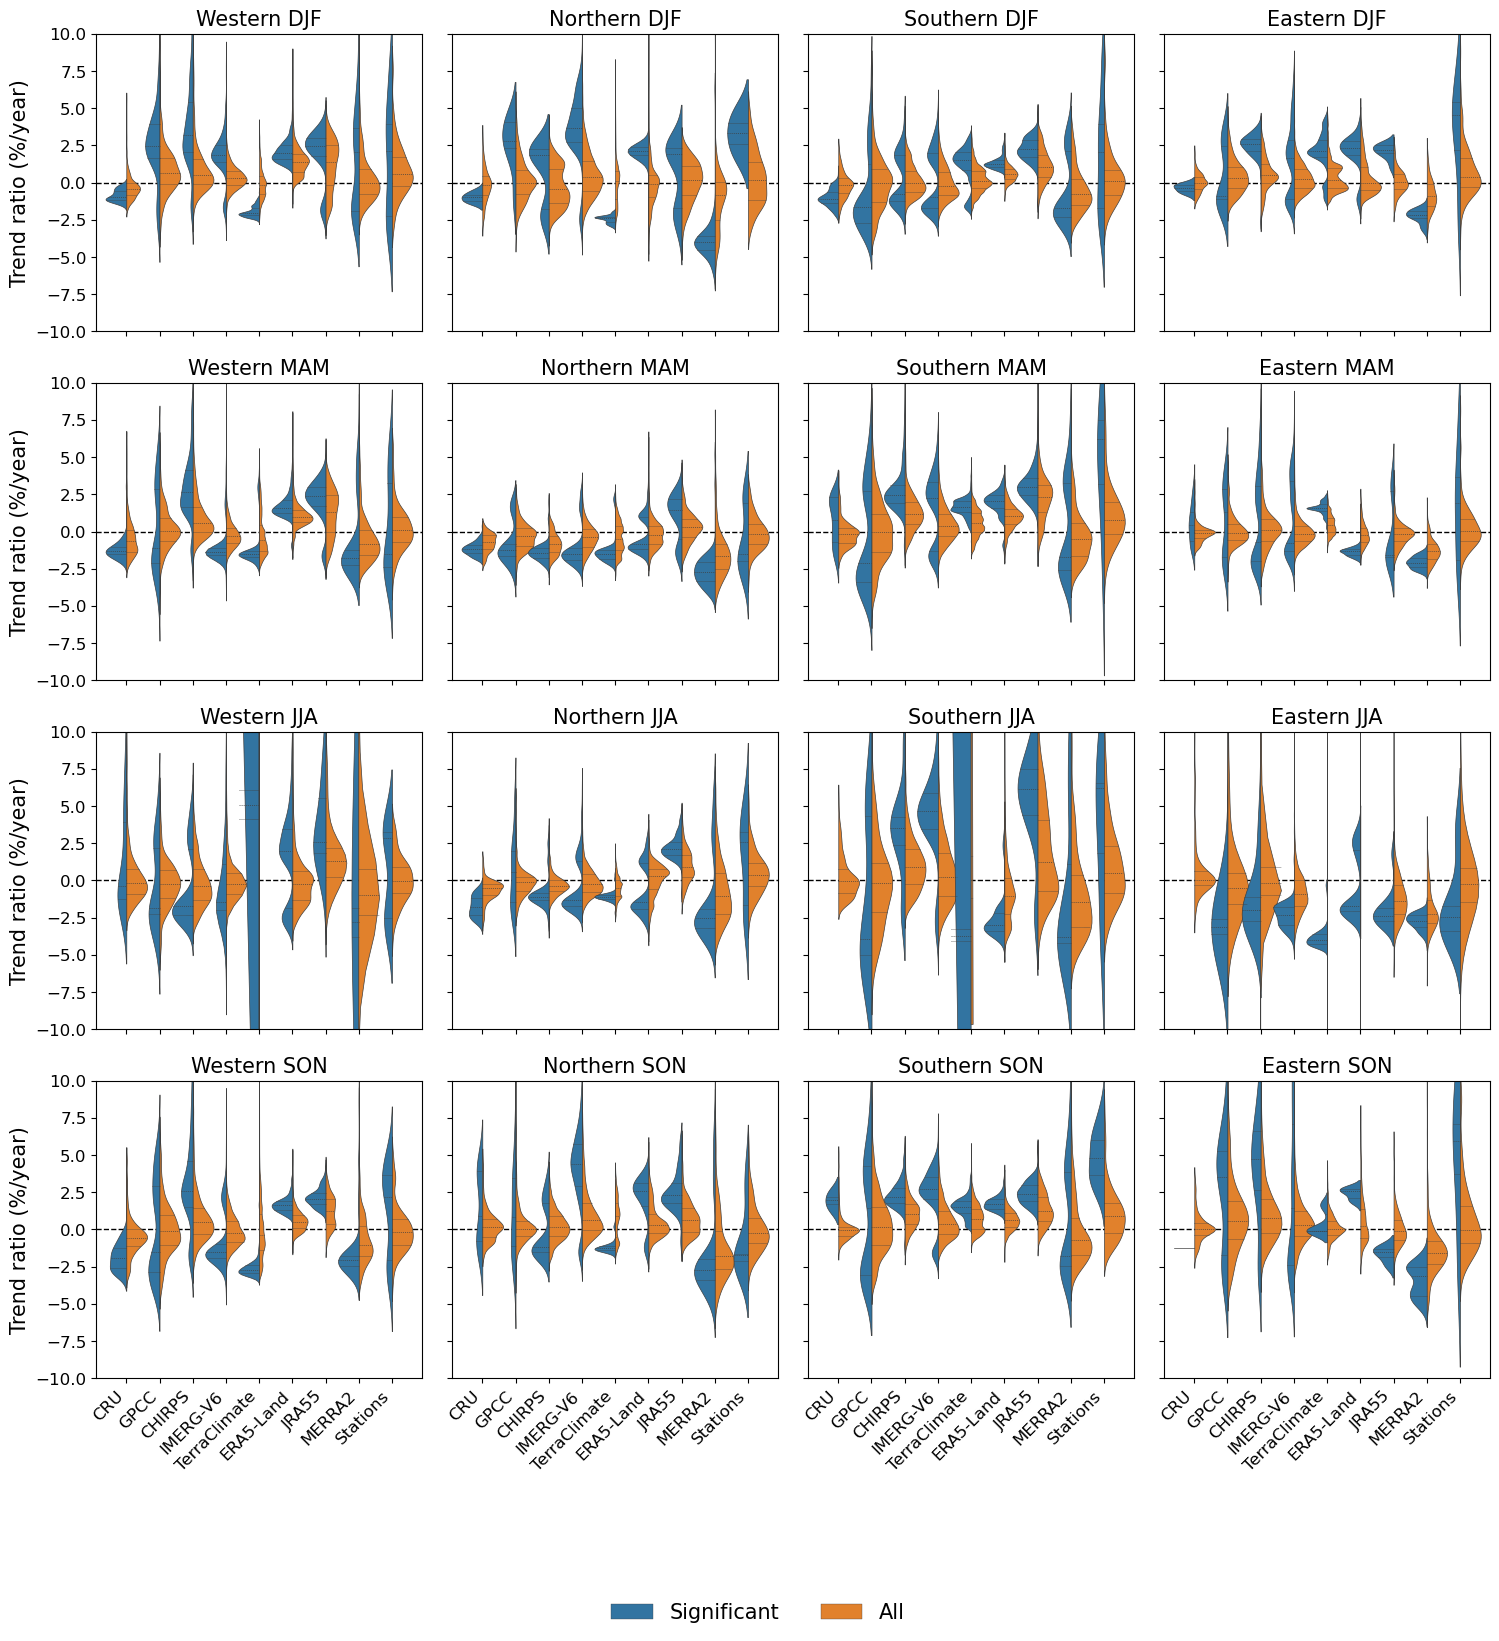

In [21]:
#plot violin plot for each season and region
fig, axes = plt.subplots(4,4, figsize=(15,15), sharex=True, sharey=True)
#font size as 12
plt.rcParams.update({'font.size': 12})
for i, region in enumerate(regions_list):
    for s, sea in enumerate(seasons):
        ax = axes[s,i]
        sns.violinplot(data=df_all[(df_all.Region==region) & (df_all.season == sea)], x='Dataset', y=var, hue='Significancy', 
                   hue_order=['Significant', 'All'], ax=ax, split=True,  
                   linewidth=0.5,width=1.25, inner='quartile')
        ax.set_title(region + ' ' + sea, fontsize=15)
        #set x lim 
        ax.set_xlim(-0.9, 8.9)
        ax.set_ylim(-10,10)
        ax.set_xlabel('')
        ax.set_ylabel('')
        #leave only the legend for last subplot
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

        ax.tick_params(axis='y', which='both', labelsize=12)
        ax.tick_params(axis='x', which='both', labelsize=12)
        #set ticks label 45 degrees
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        #horizontal line in 0
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)
        if i == 0:
            ax.set_ylabel(label_cbar, fontsize=15)
        else:
            ax.set_ylabel('')
        if s == 3:
            ax.set_xlabel('')
#add legend in the last subplot
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=2, frameon=False, fontsize=15)

plt.tight_layout()